In [1]:
#import packages
import gym
import pylab
import numpy as np

In [2]:
#instantiale parameters
no_states = 400
no_actions = 3
no_st_feature = 20
table = np.zeros((no_states,no_actions))
matrix_features = np.eye((no_states))
gamma_p= 0.99
alpha_p = 0.03
theta_p = 0.05

In [3]:
#random seed
np.random.seed(223)

In [4]:
#mapping the demo environment
def env_params(env, no_st_feature):
    env_min = env.observation_space.low
    env_max = env.observation_space.high
    dist = (env_max - env_min) / no_st_feature
    return env_min, env_max, dist

In [5]:
#mapping the index of the state
def params_state(matrix, env_min, dist, no_st_feature):
    pos_indx = int((matrix[0] - env_min[0]) / dist[0])
    vel_indx = int((matrix[1] - env_min[1]) / dist[1])
    state_indx = pos_indx + vel_indx * no_st_feature
    return state_indx

In [6]:
#mapping demonstrations
def demonstration_indx(env, no_st_feature):
    env_min, env_max, dist = env_params(env,no_st_feature)
    demo_load = np.load(file="https://raw.githubusercontent.com/PacktWorkshops/The-Reinforcement-Learning-Workshop/master/Chapter03/Dataset/Expert demonstrations.npy")
    demos = np.zeros((len(demo_load),len(demo_load[0]),3))
    for x in range(len(demo_load)):
        for y in range(len(demo_load[0])):
            state_indx = params_state(demo_load[x][y],env_min, dist, no_st_feature)
            demos[x][y][0] = state_indx
            demos[x][y][1] = demo_load[x][y][2]
    return demos


In [7]:
#mapping the index of the simulated states
def attach_state(env, state):
    env_min, env_max, dist = env_params(env, no_st_feature)
    state_indx = params_state(state, env_min, dist,no_st_feature)
    return state_indx

In [9]:
def qtable_update(current_state, action, reward,new_state):
    current_q = table[current_state][action]
    new_q = reward + gamma_p * max(table[new_state])
    table[current_state][action] += alpha_p * (new_q - current_q)

In [10]:
def expert_config(matrix_features, demonstrations):
    feat_exp = np.zeros(matrix_features.shape[0])

    for demonstration in demonstrations:
        for state_indx, _, _ in demonstration:
            feat_exp += matrix_features[int(state_indx)]

    feat_exp /= demonstrations.shape[0]
    return feat_exp

In [11]:
def inverse_rl(expert, learner, theta, alpha):
    difference = expert - learner
    theta += alpha * difference
    for j in range(len(theta)):
        if theta[j] > 0:
            theta[j] = 0

In [12]:
def use_reward(matrix_features, theta, no_states, state_indx):
    rewards_demon = matrix_features.dot(theta).reshape((no_states,))
    return rewards_demon[state_indx]

Average reward for episode 0 is -200.0


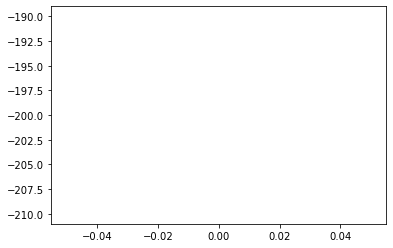

Average reward for episode 500 is -200.0


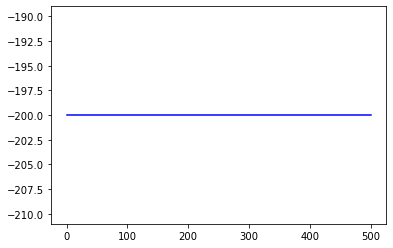

Average reward for episode 1000 is -200.0


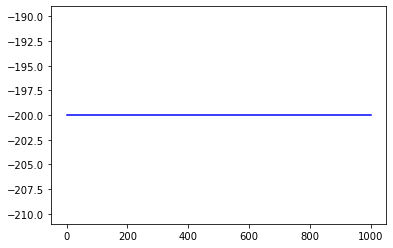

Average reward for episode 1500 is -199.95802798134577


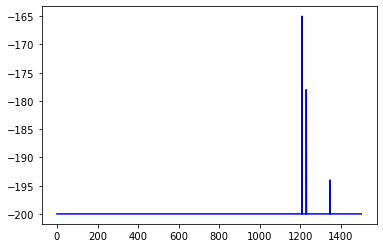

Average reward for episode 2000 is -199.96801599200398


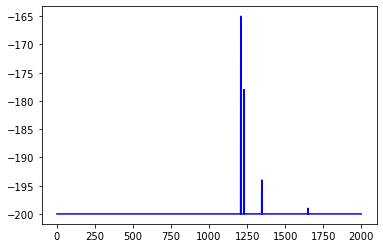

Average reward for episode 2500 is -199.97441023590565


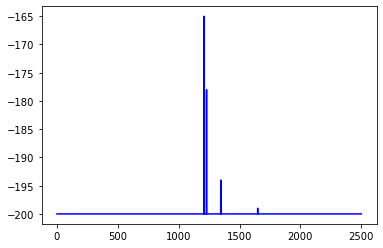

In [13]:
def main():
    env = gym.make('MountainCar-v0')
    demonstrations = demonstration_indx(env,no_st_feature)
    expert = expert_config(matrix_features, demonstrations)
    learner_features = np.zeros(no_states)
    theta = -(np.random.uniform(size =(no_states,)))
    episodes, rewards = [], []

    for episode in range (3000):
        current_state = env.reset()
        score = 0
        if(episode != 0 and episode == 1000) or (episode > 1000 and episode % 500 == 0):
            learner = learner_features / episode
            inverse_rl(expert, learner, theta, theta_p)

        while True:
            state_indx = attach_state(env, current_state)
            action = np.argmax(table[state_indx])
            new_state, reward, done, _ = env.step(action)

            reward_demo = use_reward(matrix_features, theta, no_states,state_indx)
            new_state_indx = attach_state(env, new_state)
            qtable_update(state_indx,action,reward_demo,new_state_indx)
            learner_features += matrix_features[int(state_indx)]

            score += reward
            current_state = new_state

            if done:
                rewards.append(score)
                episodes.append(episode)
                break

        if episode % 500 == 0:
            mean = np.mean(rewards)
            print("Average reward for episode {} is {}".format(episode,mean))
            pylab.plot(episodes, rewards, 'b')
            pylab.show()
            # pylab.savefig("values.png")
            # np.save("q_table", arr = table)

if __name__ == '__main__':
    main()